In [52]:
import pandas as pd 
from skimage import io, transform
import os 
import torch as torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
import cv2

In [2]:

class YourDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_files = os.listdir(os.path.join(data_path, 'data_og'))  # Assuming images are in 'images' subdirectory
        self.label_files = os.listdir(os.path.join(data_path, 'labels_og')) # Assuming labels are in 'labels' subdirectory

    def __len__(self):
        return len(self.image_files)  # Assuming images and labels have the same number of files

    def __getitem__(self, index):
        img_name = os.path.join(self.data_path, 'data_og', self.image_files[index])
        label_name = os.path.join(self.data_path, 'labels_og', self.label_files[index])

        #image = Image.open(img_name).convert('L')  # Load image (assuming RGB format)
        #label = Image.open(label_name).convert('L')   # Load label (assuming grayscale)]

        image= cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        label= cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label


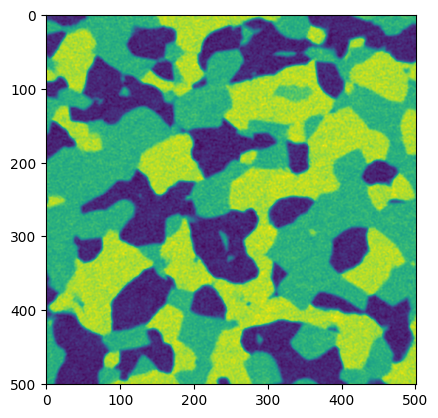

In [3]:
a = YourDataset(data_path="C:\\Users\\adop\\Desktop\\Dl", transform=transforms.ToTensor())
img = a.__getitem__(0)
plt.imshow(img[0].squeeze())
#plt.imshow(img[1])
#size for image and label is 501*501
loaddata = DataLoader(a, batch_size=5, shuffle=True)

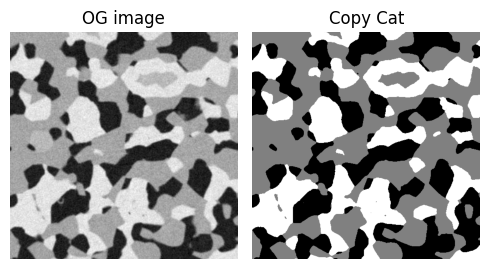

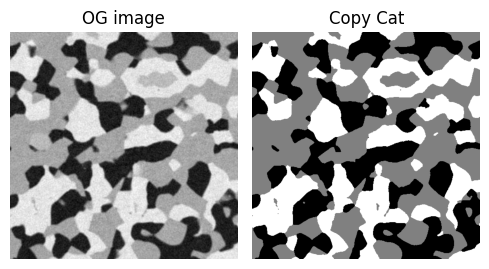

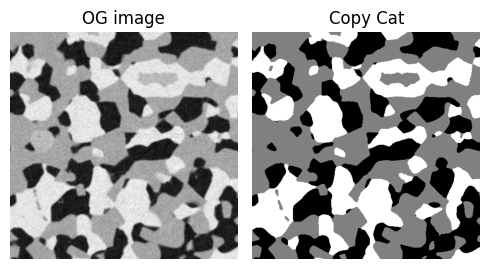

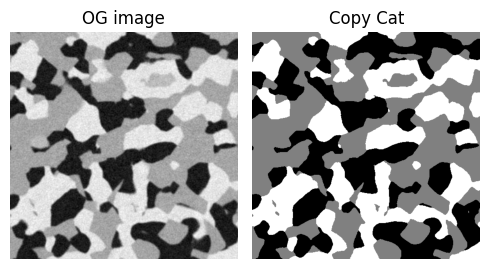

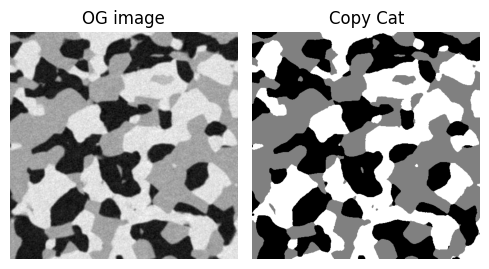

torch.Size([1, 501, 501])


In [26]:
for i, batch in enumerate(loaddata):
    input, target = batch

    # Assuming input and target are tensors
    input_image = input[i].numpy().squeeze()
    target_image = target[i].numpy().squeeze()

    # Displaying the images with titles using Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(5,5))

    # Displaying the original (input) image with a title 'OG image'
    axes[0].imshow(input_image, cmap='gray')  # Assuming it's a grayscale image
    axes[0].set_title('OG image')

    # Displaying the target image with a title 'Copy Cat'
    axes[1].imshow(target_image, cmap='gray')  # Assuming it's a grayscale image
    axes[1].set_title('Copy Cat')

    # Hide axes and display the plot
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
print(target[0].shape)

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class DownLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownLayer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class UpLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpLayer, self).__init__()
        self.up = Up(in_ch, out_ch)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(nn.Module):
    def __init__(self, dimensions=2):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(1, 64)
        self.down1 = DownLayer(64, 128)
        self.down2 = DownLayer(128, 256)
        self.down3 = DownLayer(256, 512)
        self.down4 = DownLayer(512, 1024)
        self.up1 = UpLayer(1024, 512)
        self.up2 = UpLayer(512, 256)
        self.up3 = UpLayer(256, 128)
        self.up4 = UpLayer(128, 64)
        self.last_conv = nn.Conv2d(64, dimensions, 1)

    def forward(self, x):
        intermid = []
        x1 = self.conv1(x)
        intermid.append(x1.clone())
        x2 = self.down1(x1)
        intermid.append(x2.clone())
        x3 = self.down2(x2)
        intermid.append(x3.clone())
        x4 = self.down3(x3)
        intermid.append(x4.clone())
        x5 = self.down4(x4)
        intermid.append(x5.clone())
        x1_up = self.up1(x4, x5)
        x2_up = self.up2(x3, x1_up)
        x3_up = self.up3(x2, x2_up)
        x4_up = self.up4(x1, x3_up)
        output = self.last_conv(x4_up)
        return output


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_path = "model/unet-voc.pt"


cpu


In [51]:
epoch_number = 2
saving_interval = 10
model = UNet(dimensions=2)

def train():

    #model = UNet(dimensions=22)
    model.to(device)
    optimizer = optim.RMSprop(
        model.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9
    )
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epoch_number):
        print(f"Epoch {epoch}")
        losses = []
        for i, batch in enumerate(loaddata):
            input, target = batch
            input = input.to(device)
            print(input[i].shape)
            target = target.type(torch.LongTensor).to(device)
            print(target[i].shape)
            # HACK to skip the last item that has a batch size of 1, not working with the cross entropy implementation
            if input.shape[0] < 2:
                continue
            #if i == 0 and epoch == 0:
                #visualize_sample(input)
            optimizer.zero_grad()
            output = model(input)
            print(output.shape)
            if i ==0 and epoch ==0:
                visualize_sample(output)
            loss = criterion(output, target.squeeze())  #how far off we are from target image. 
            # step_loss = loss.item()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        # print the average loss for that epoch.
        print(sum(losses) /len(losses))
        if (epoch + 1) % saving_interval == 0:
            print("Saving model")

        torch.save(model.state_dict(), model_path)
    torch.save(model.state_dict(), model_path)
    return 

def visualize_sample(input_batch):
    # Assuming input_batch is a batch of images (adjust indexing based on your batch structure)
    #num_samples = min(4)  # Display a maximum of 4 samples
    
    fig, axes = plt.subplots(1, figsize=(5, 5))
    
    for i in range(1):
        #image_array = input_batch[i].cpu().numpy().squeeze()  # Convert tensor to numpy array
        image_array=input_batch[i].cpu().detach().numpy().squeeze()

        plt.imshow(image_array[0,: ,:], cmap='gray')
        plt.title('Original Image')
        #axes[i].imshow(image_array, cmap='gray')  # Display the image
        #axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [53]:
def display_feature_maps(feature_maps):
    num_maps = len(feature_maps)
    fig, axs = plt.subplots(1, num_maps, figsize=(15, 5))

    for i in range(num_maps):
        # Convert tensor to numpy array and normalize for visualization
        img = feature_maps[i].detach().cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

        # If the tensor has multiple channels (e.g., RGB), visualize each channel separately
        if img.shape[1] > 1:
            # Displaying each channel separately for multi-channel feature maps
            for j in range(img.shape[1]):
                axs[i].imshow(img[0, j, :, :], cmap='gray')  # Assuming grayscale visualization
                axs[i].axis('off')
                axs[i].set_title(f"Channel {j + 1}")
        else:
            # For single-channel feature maps, display directly
            axs[i].imshow(img.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension if it exists
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you want to display all the intermediate feature maps

NameError: name 'intermid' is not defined

Epoch 0
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])


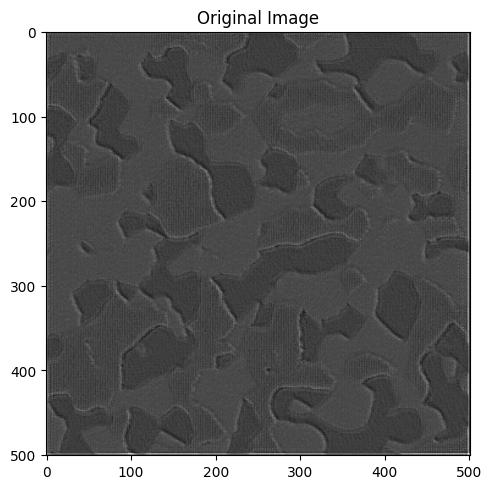

torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
2.2525265216827393
Epoch 1
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
torch.Size([1, 501, 501])
torch.Size([1, 501, 501])
torch.Size([5, 22, 501, 501])
1.2653757810592652


UNet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownLayer(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [50]:
train()
model.eval()

NameError: name 'inputs' is not defined

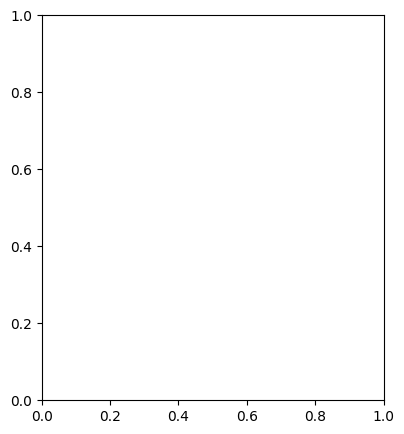

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
img_original = inputs[0].cpu()[0,:,:]
plt.imshow(img_original, cmap='gray')
plt.title('Original Image')

# Plot the labeled image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
img_labeled = prob_to_gray(labels[0].cpu())
plt.imshow(img_labeled, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')

# Plot the prediction image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
#img_predicted = prob_to_gray(pred[:,0])
img_predicted = prob_to_gray(pred[0])
plt.imshow(img_predicted, cmap='gray')
plt.title('Prediction')

# Show the plot
plt.show()